In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from miditok import MIDILike, TokenizerConfig, REMI
from miditoolkit import MidiFile # For creating dummy files
from pathlib import Path
import numpy as np
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import pretty_midi
import io
import os
import random

In [98]:
import torch
print(torch.cuda.is_available())  # should be True
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
5
NVIDIA GeForce RTX 3080


In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [43]:
def get_REMI():
    MIDI_FOLDER = Path("../../data/popmusic/train")
    TOKENIZER_PARAMS = {
        "pitch_range": (0, 127),
        "num_velocities": 10,
        "special_tokens": ["PAD", "EOS", "BOS"], 
        "use_chords": True,
        "use_rests": True, # Rests can be musically important
        "use_tempos": True,
        "use_time_signatures": True, # 
        "use_programs": False,
    }
    tokenizer = REMI(TokenizerConfig(**TOKENIZER_PARAMS))
    return tokenizer


In [44]:
tokenizer = get_REMI()

In [45]:
PAD_TOKEN_ID = tokenizer.vocab["PAD_None"]
VOCAB_SIZE = len(tokenizer.vocab)
print(f"Vocabulary Size: {VOCAB_SIZE}")
print(f"PAD ID: {PAD_TOKEN_ID}")
print(f"Special Tokens: {tokenizer.special_tokens}")

Vocabulary Size: 449
PAD ID: 0
Special Tokens: ['PAD_None', 'EOS_None', 'BOS_None']


In [46]:
print(tokenizer.vocab.keys())

dict_keys(['PAD_None', 'EOS_None', 'BOS_None', 'Bar_None', 'Pitch_0', 'Pitch_1', 'Pitch_2', 'Pitch_3', 'Pitch_4', 'Pitch_5', 'Pitch_6', 'Pitch_7', 'Pitch_8', 'Pitch_9', 'Pitch_10', 'Pitch_11', 'Pitch_12', 'Pitch_13', 'Pitch_14', 'Pitch_15', 'Pitch_16', 'Pitch_17', 'Pitch_18', 'Pitch_19', 'Pitch_20', 'Pitch_21', 'Pitch_22', 'Pitch_23', 'Pitch_24', 'Pitch_25', 'Pitch_26', 'Pitch_27', 'Pitch_28', 'Pitch_29', 'Pitch_30', 'Pitch_31', 'Pitch_32', 'Pitch_33', 'Pitch_34', 'Pitch_35', 'Pitch_36', 'Pitch_37', 'Pitch_38', 'Pitch_39', 'Pitch_40', 'Pitch_41', 'Pitch_42', 'Pitch_43', 'Pitch_44', 'Pitch_45', 'Pitch_46', 'Pitch_47', 'Pitch_48', 'Pitch_49', 'Pitch_50', 'Pitch_51', 'Pitch_52', 'Pitch_53', 'Pitch_54', 'Pitch_55', 'Pitch_56', 'Pitch_57', 'Pitch_58', 'Pitch_59', 'Pitch_60', 'Pitch_61', 'Pitch_62', 'Pitch_63', 'Pitch_64', 'Pitch_65', 'Pitch_66', 'Pitch_67', 'Pitch_68', 'Pitch_69', 'Pitch_70', 'Pitch_71', 'Pitch_72', 'Pitch_73', 'Pitch_74', 'Pitch_75', 'Pitch_76', 'Pitch_77', 'Pitch_78', 'Pi

In [47]:
print(tokenizer.vocab.values())

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [48]:
token_to_event = {token: event for event, token in tokenizer.vocab.items()}

In [54]:
midi_paths = list(Path("../../data/popmusic/train").glob("*.midi"))

In [55]:
len(midi_paths)

775

In [58]:
len(tokenizer(Path(midi_paths[0]))[0])

2068

In [34]:
#tokens = tokenizer("../../data/mono-midi/train/167172.mid") a broken file

In [59]:
lengths = []
for midi_path in midi_paths:

        #tokens = tokenizer.encode(midi_path)[0] #we need to add .encode to get the tokens, otherwise it returns a list of events
    try: 
        tokens = tokenizer(Path(midi_path))
        lengths.append(len(tokens[0])) #tokens[0] is the list of events, tokens[1] is the list of tokens
        # if len(tokens[0]) > 10000:
        #     print(f"File {midi_path} is long with {len(tokens[0])} tokens")
            
    except:
        print(f"Error with {midi_path}")
        continue

    

In [60]:
sorted(lengths, reverse=True)

[23080,
 15657,
 15191,
 15051,
 14840,
 14612,
 14264,
 13926,
 13755,
 13488,
 13141,
 12956,
 12911,
 12379,
 12288,
 12123,
 12068,
 12058,
 12056,
 12035,
 11987,
 11759,
 11715,
 11587,
 11355,
 11350,
 11342,
 11277,
 10741,
 10643,
 10577,
 10562,
 10453,
 10223,
 10216,
 9770,
 9705,
 9631,
 9626,
 9563,
 9501,
 9486,
 9391,
 9369,
 9321,
 9264,
 9225,
 9198,
 9112,
 9084,
 9048,
 8864,
 8840,
 8777,
 8758,
 8724,
 8724,
 8718,
 8705,
 8556,
 8511,
 8427,
 8388,
 8376,
 8350,
 8331,
 8291,
 8257,
 8242,
 8172,
 8021,
 7991,
 7951,
 7911,
 7867,
 7864,
 7858,
 7821,
 7790,
 7642,
 7624,
 7612,
 7594,
 7591,
 7583,
 7583,
 7581,
 7518,
 7510,
 7510,
 7475,
 7462,
 7447,
 7444,
 7439,
 7432,
 7396,
 7374,
 7371,
 7356,
 7341,
 7319,
 7278,
 7276,
 7251,
 7249,
 7230,
 7210,
 7209,
 7202,
 7193,
 7186,
 7114,
 7083,
 7076,
 7072,
 7060,
 7055,
 7049,
 7048,
 7019,
 7013,
 6985,
 6984,
 6973,
 6952,
 6944,
 6931,
 6928,
 6892,
 6892,
 6879,
 6874,
 6855,
 6842,
 6833,
 6821,
 6809,

(array([ 1.,  2.,  1.,  3.,  7.,  5.,  5., 12.,  9., 18., 14.,  9., 18.,
        19., 29., 30., 37., 54., 66., 54., 53., 38., 47., 58., 21., 26.,
        17., 15., 14., 14.,  5.,  4.,  4.,  6.,  6.,  3.,  4.,  5.,  5.,
         2.,  0.,  2.,  1.,  4.,  0.,  0.,  4.,  1.,  2.,  5.,  2.,  1.,
         0.,  1.,  2.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1059.  ,  1279.21,  1499.42,  1719.63,  1939.84,  2160.05,
         2380.26,  2600.47,  2820.68,  3040.89,  3261.1 ,  3481.31,
         3701.52,  3921.73,  4141.94,  4362.15,  4582.36,  4802.57,
         5022.78,  5242.99,  5463.2 ,  5683.41,  5903.62,  6123.83,
         6344.04,  6564.25,  6784.46,  7004.67,  7224.88,  7445.09,
         7665.3 ,  7885.51,  8105.72,  8325.93,  8546.14,  8766.35,
         8986.56,  9206.77

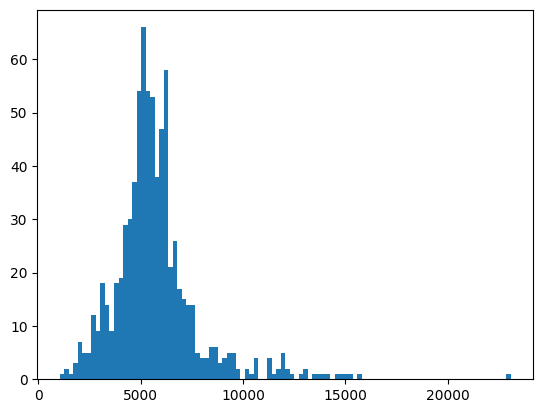

In [61]:
plt.hist(lengths, bins=100)

In [24]:
np.min(lengths), np.max(lengths), np.mean(lengths), np.std(lengths)

(5, 23048, 700.833, 1044.0851445696371)

In [ ]:

def get_midi_chunks(midi_paths, tokenizer, chunk_len):

    all_chunks = []
    all_chunks_events = []
    for midi_path in midi_paths:
        #tokens = tokenizer.encode(midi_path)[0] #we need to add .encode to get the tokens, otherwise it returns a list of events
        tokens = tokenizer(Path(midi_path)) 

        i = 0
        while i < len(tokens):

            chunk = tokens[i:i+chunk_len]
            if len(chunk) >= min_token:
                #torch.tensor is tokenizating the midi tokens
                all_chunks_events.append(chunk)
                tokenized_chunk = torch.tensor(chunk, dtype=torch.long)
                all_chunks.append(tokenized_chunk)
            i += chunk_len

    # Pad all chunks to max_token length
    # padded_chunks = pad_sequence(
    #     [c[:max_token] if len(c) > max_token else c for c in all_chunks],
    #     batch_first=True,
    #     padding_value=PAD_TOKEN_ID
        
    # )

    #convert all_chunks to a tensor without padding
    #all_chunks = torch.stack(all_chunks, dim=0)

    return all_chunks, all_chunks_events



In [88]:
def chunk_midi_tokens_from_folder(midi_paths, chunk_size, tokenizer):
    chunks = []
    for midi_path in midi_paths[:500]:
        tokens = tokenizer(Path(midi_path))[0]

        # Chunking the tokens
        
        for i in range(0, len(tokens), chunk_size):
            chunk = tokens[i : i + chunk_size]
            chunks.append(torch.tensor(chunk.ids))

        print(f"Created {len(chunks)} chunks of (up to) {chunk_size} tokens each.")


    return chunks


In [89]:
chunks = chunk_midi_tokens_from_folder(midi_paths, 500, tokenizer)

Created 5 chunks of (up to) 500 tokens each.
Created 16 chunks of (up to) 500 tokens each.
Created 27 chunks of (up to) 500 tokens each.
Created 38 chunks of (up to) 500 tokens each.
Created 56 chunks of (up to) 500 tokens each.
Created 64 chunks of (up to) 500 tokens each.
Created 70 chunks of (up to) 500 tokens each.
Created 80 chunks of (up to) 500 tokens each.
Created 89 chunks of (up to) 500 tokens each.
Created 99 chunks of (up to) 500 tokens each.
Created 106 chunks of (up to) 500 tokens each.
Created 118 chunks of (up to) 500 tokens each.
Created 131 chunks of (up to) 500 tokens each.
Created 141 chunks of (up to) 500 tokens each.
Created 149 chunks of (up to) 500 tokens each.
Created 163 chunks of (up to) 500 tokens each.
Created 176 chunks of (up to) 500 tokens each.
Created 191 chunks of (up to) 500 tokens each.
Created 205 chunks of (up to) 500 tokens each.
Created 215 chunks of (up to) 500 tokens each.
Created 223 chunks of (up to) 500 tokens each.
Created 246 chunks of (u

In [106]:
len(chunks[0])

500

In [91]:
chunks[0] #maybe need to split based on bar_none tokens, since need to start at bar_none

tensor([  3, 448, 205, 420, 383, 213, 408, 383, 221, 416,  93, 135, 156,  83,
        134, 157,  86, 134, 156,  89, 134, 156, 229, 415,   3, 448, 205, 416,
         82, 134, 166,  92, 134, 149,  85, 135, 164,  88, 135, 164, 213, 415,
        221, 416, 229, 415,  80, 134, 171,  85, 135, 168,  88, 135, 165,   3,
        448, 205, 415, 213, 416, 221, 415,  75, 134, 189, 223,  79, 134, 189,
        224,  82, 134, 188, 225,  85, 135, 187, 227,  87, 135, 186, 229, 416,
          3, 448, 205, 416, 213, 424, 221, 423, 229, 422,   3, 448, 205, 423,
        221, 424, 379, 229,  44, 133, 148,   3, 448, 205, 426, 362,  56, 134,
        142,  59, 133, 143,  63, 134, 143, 380, 213,  63, 134, 143,  56, 134,
        141,  59, 134, 141, 380, 221, 425,  39, 134, 149,  51, 134, 149, 229,
        425, 362,  56, 134, 142,  59, 134, 142,  63, 134, 143, 380, 205, 426,
        362,  56, 134, 142,  59, 134, 142,  63, 134, 142, 381, 213, 425,  44,
        134, 149, 220,  56, 134, 143,  63, 134, 143, 221, 426,  

In [92]:
decoded_midi = tokenizer([chunks[586]])
decoded_midi.dump_midi(Path("decoded_midi.mid"))
midi_data = pretty_midi.PrettyMIDI("decoded_midi.mid")
audio = midi_data.synthesize(fs=22050)
Audio(audio, rate=22050)

In [94]:
class MidiDataset(Dataset):
    def __init__(self, token_chunks):
        self.data_split = token_chunks

    def __len__(self):
        return len(self.data_split)

    def __getitem__(self, idx):
        tokenized_chunk = self.data_split[idx]
        return tokenized_chunk[:-1], tokenized_chunk[1:] 

In [95]:
from sklearn.model_selection import train_test_split
train_chunks, val_chunks = train_test_split(chunks, test_size=0.25)

In [ ]:
from keras import backend as ops

def get_dataloaders(train_midi, val_midi, token_length, batch_size):

    train_dataset = MidiDataset(train_midi)
    val_dataset = MidiDataset(val_midi)
    #pad the sequences in the batch to maximum length
        # Pad all chunks to max_token length
    def padded_batch(batch):
        inputs, outputs = zip(*batch)
        
        # The pad_sequence fn expects torch Tensors. The following conversion is only necessary for TF backend
        inputs = [torch.tensor(t).to(device) for t in inputs]
        outputs = [torch.tensor(l).to(device) for l in outputs]
        
        inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=PAD_TOKEN_ID)
        outputs = torch.nn.utils.rnn.pad_sequence(outputs, batch_first=True, padding_value=PAD_TOKEN_ID)

        return inputs, outputs
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=padded_batch)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=padded_batch)


    return train_loader, val_loader

In [104]:

train_loader, val_loader = get_dataloaders(train_chunks, val_chunks, 500, 32)

In [ ]:
for batch in train_loader:
    inputs, outputs = batch
    print(f"Inputs: {inputs.shape}")
    print(f"Outputs: {outputs.shape}")
    break
#499 because the input and output are shifted by one

Inputs: torch.Size([32, 499])
Outputs: torch.Size([32, 499])


/tmp/ipykernel_84941/135822752.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(t).to(device) for t in inputs]
/tmp/ipykernel_84941/135822752.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [torch.tensor(l).to(device) for l in outputs]


In [107]:
inputs, outputs = next(iter(train_loader))
print(inputs)
print(outputs)

tensor([[162, 209,  77,  ...,  84, 136, 156],
        [145,   3, 448,  ...,  80, 136, 145],
        [ 59, 134, 156,  ..., 135, 149, 225],
        ...,
        [136, 147, 231,  ..., 143,  55, 135],
        [146, 215,  74,  ...,   3, 448, 205],
        [148,  74, 136,  ..., 152,  64, 135]], device='cuda:0')
tensor([[209,  77, 136,  ..., 136, 156,  41],
        [  3, 448, 205,  ..., 136, 145, 233],
        [134, 156,  69,  ..., 149, 225,  64],
        ...,
        [147, 231,  86,  ...,  55, 135, 146],
        [215,  74, 135,  ..., 448, 205, 420],
        [ 74, 136, 148,  ...,  64, 135, 161]], device='cuda:0')


/tmp/ipykernel_84941/135822752.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(t).to(device) for t in inputs]
/tmp/ipykernel_84941/135822752.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [torch.tensor(l).to(device) for l in outputs]


In [108]:
import torch
import torch.nn as nn

class MidiGRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, gru_units):
        super(MidiGRUModel, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=PAD_TOKEN_ID)

        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=gru_units, batch_first=True)

        self.output_layer = nn.Linear(in_features=gru_units, out_features=vocab_size)

    def forward(self, x, hidden=None):
        """
        x: Tensor of shape (batch_size, sequence_length)
        hidden: initial hidden state for the GRU, shape (1, batch_size, gru_units)
        """
        embedded = self.embedding(x)  # (batch_size, sequence_length, embedding_dim)

        gru_output, hidden = self.gru(embedded, hidden)  # gru_output: (batch_size, sequence_length, gru_units)

        logits = self.output_layer(gru_output)  # (batch_size, sequence_length, vocab_size)

        return logits, hidden

In [109]:
model = MidiGRUModel(vocab_size=VOCAB_SIZE, embedding_dim=256, gru_units=512).to(device)

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt # For plotting



# --- Optimizer and Loss ---
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Initial learning rate
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN_ID)

# --- Scheduler ---
# Use ReduceLROnPlateau - it needs a metric from the validation set
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # Reduce LR when the metric has stopped decreasing
    factor=0.5,      # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3,      # Number of epochs with no improvement after which learning rate will be reduced.
    verbose=True     # Prints a message when LR is updated
)
# If you wanted StepLR instead (remove or comment out ReduceLROnPlateau):
# scheduler_steplr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)






In [112]:
num_epochs = 100
train_losses = []
val_losses = []
learning_rates = [] # To track learning rate changes

print(f"Starting training for {num_epochs} epochs on {device}...")

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # Set model to training mode
    total_train_loss = 0
    batch_count_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        logits, _ = model(inputs) # Assuming your model returns (logits, hidden_state)
        loss = criterion(logits.view(-1, VOCAB_SIZE), targets.view(-1))

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        batch_count_train += 1

    avg_train_loss = total_train_loss / batch_count_train if batch_count_train > 0 else 0
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    batch_count_val = 0
    with torch.no_grad():  # Disable gradient calculations for validation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits, _ = model(inputs)
            loss = criterion(logits.view(-1, VOCAB_SIZE), targets.view(-1))
            total_val_loss += loss.item()
            batch_count_val += 1

    avg_val_loss = total_val_loss / batch_count_val if batch_count_val > 0 else 0
    val_losses.append(avg_val_loss)

    # --- Scheduler Step ---
    # For ReduceLROnPlateau, step with the validation loss
    scheduler.step(avg_val_loss)
    # For StepLR (if you were using that one instead):
    # scheduler_steplr.step()

    # Store current learning rate
    learning_rates.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Optional: Save model checkpoint based on validation loss
    # if epoch == 0 or avg_val_loss < min_val_loss:
    #     min_val_loss = avg_val_loss
    #     torch.save(model.state_dict(), 'best_model.pth')
    #     print(f"Saved best model checkpoint at epoch {epoch+1}")


print("Training finished.")

Starting training for 100 epochs on cuda...


/tmp/ipykernel_84941/135822752.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(t).to(device) for t in inputs]
/tmp/ipykernel_84941/135822752.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = [torch.tensor(l).to(device) for l in outputs]


Epoch 1/100, Train Loss: 2.9285, Val Loss: 2.3667, LR: 0.001000
Epoch 2/100, Train Loss: 2.1776, Val Loss: 2.0397, LR: 0.001000
Epoch 3/100, Train Loss: 1.9723, Val Loss: 1.9218, LR: 0.001000
Epoch 4/100, Train Loss: 1.8828, Val Loss: 1.8633, LR: 0.001000
Epoch 5/100, Train Loss: 1.8252, Val Loss: 1.8209, LR: 0.001000
Epoch 6/100, Train Loss: 1.7802, Val Loss: 1.7906, LR: 0.001000
Epoch 7/100, Train Loss: 1.7431, Val Loss: 1.7699, LR: 0.001000
Epoch 8/100, Train Loss: 1.7118, Val Loss: 1.7491, LR: 0.001000
Epoch 9/100, Train Loss: 1.6824, Val Loss: 1.7352, LR: 0.001000
Epoch 10/100, Train Loss: 1.6568, Val Loss: 1.7237, LR: 0.001000
Epoch 11/100, Train Loss: 1.6332, Val Loss: 1.7134, LR: 0.001000
Epoch 12/100, Train Loss: 1.6108, Val Loss: 1.7065, LR: 0.001000
Epoch 13/100, Train Loss: 1.5903, Val Loss: 1.7021, LR: 0.001000
Epoch 14/100, Train Loss: 1.5715, Val Loss: 1.6986, LR: 0.001000
Epoch 15/100, Train Loss: 1.5530, Val Loss: 1.6995, LR: 0.001000
Epoch 16/100, Train Loss: 1.5364, 

KeyboardInterrupt: 

In [122]:
torch.save(model.state_dict(), '1layer_gru_weights.pth')

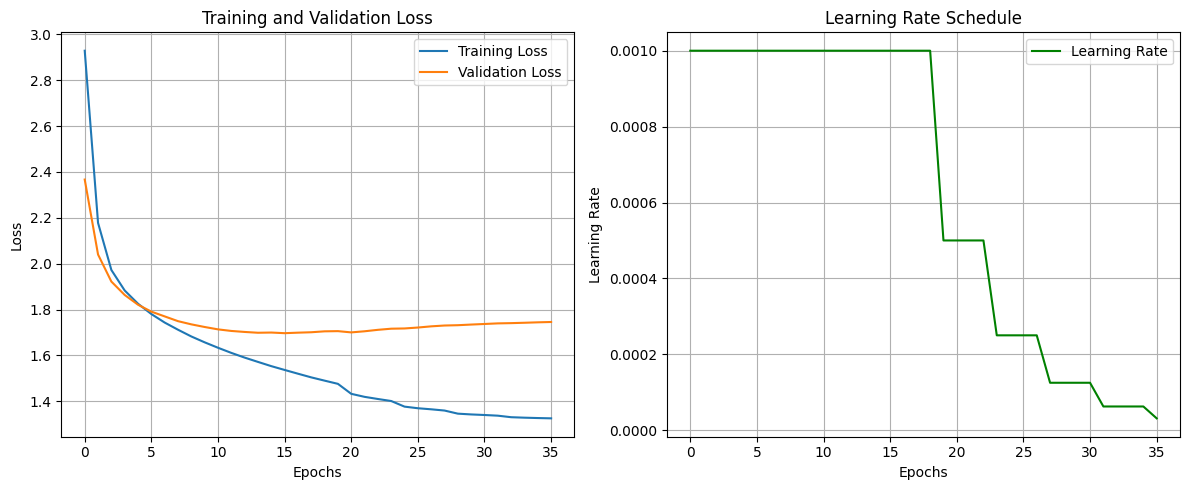

In [113]:
# --- Plotting Training and Validation Loss ---
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Learning Rate
plt.subplot(1, 2, 2)
plt.plot(learning_rates, label='Learning Rate', color='green')
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [114]:
def sample_token(model, token_sequence, hidden_state=None):
    """
    Args:
        model: your PyTorch model (embedding + GRU + linear)
        token_sequence: LongTensor of shape (batch_size, seq_len)
        hidden_state: initial hidden state for GRU, or None

    Returns:
        samples: LongTensor of shape (batch_size, 1) sampled tokens from logits
        updated_hidden_state: GRU hidden state after processing token_sequence
        final_step_logits: Tensor (batch_size, vocab_size) logits for last timestep
    """
    model.eval()
    with torch.no_grad():
        # forward pass through model
        logits, updated_hidden_state = model(token_sequence, hidden_state)

        # logits shape: (batch_size, seq_len, vocab_size)
        final_step_logits = logits[:, -1, :]  # last timestep logits

        # sample from logits (multinomial sampling)
        probs = torch.nn.functional.softmax(final_step_logits, dim=-1)
        samples = torch.multinomial(probs, num_samples=1)  # shape: (batch_size, 1)

    return samples, updated_hidden_state, final_step_logits

In [116]:

_,_,logit_distribution = sample_token(model, torch.tensor([[2]]).to(device)) # pass in one element in the batch

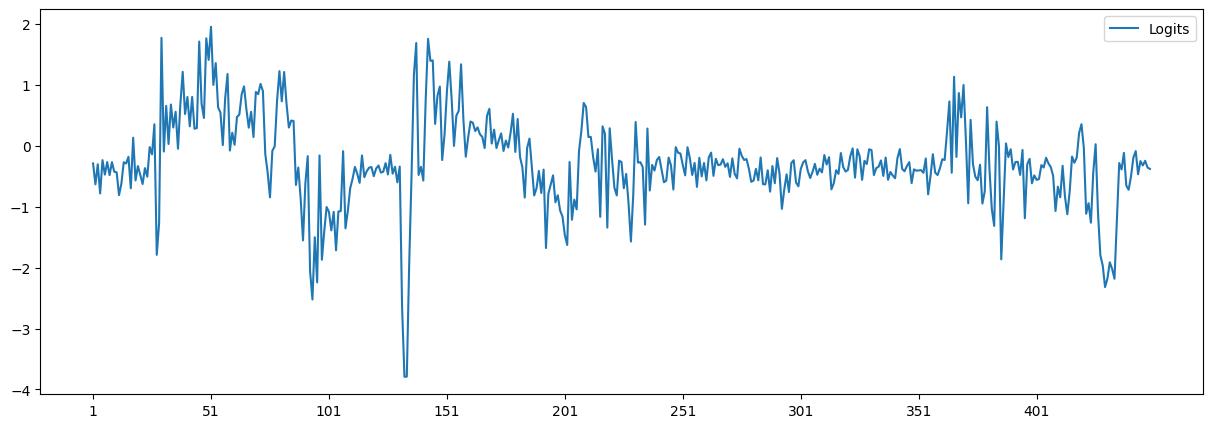

In [117]:
plt.figure(figsize=(15,5))

# Move the tensor to CPU and convert to numpy
logits_cpu = logit_distribution[0].cpu().numpy()

plt.plot(logits_cpu, label='Logits')

num_tokens = len(logits_cpu)
tick_positions = np.arange(0, num_tokens, 50)
plt.xticks(tick_positions, 1 + tick_positions)
plt.legend(loc='upper right')
plt.show()

In [118]:
def generate_midi(model, start_sequence, max_length):
    model.eval()
    generated_sequence = list(start_sequence)
    initial_state = None

    for _ in range(max_length):
        token_tensor = torch.LongTensor(generated_sequence).unsqueeze(0).to(device)
        sample, initial_state, _ = sample_token(model, token_tensor, initial_state)
        # Move sample to CPU before converting to numpy
        generated_sequence.append(sample.cpu().numpy()[0][0])
    return generated_sequence


In [119]:
output_dir = Path("../Generatedmidi_pop_REMI")
output_dir.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists

def get_next_filename(base_dir, base_name="generated_midi", ext=".mid"):
    existing_files = list(base_dir.glob(f"{base_name}*.mid"))
    existing_nums = []
    for f in existing_files:
        # Extract the number suffix, e.g. generated_midi5.mid -> 5
        stem = f.stem  # e.g. 'generated_midi5'
        suffix = stem.replace(base_name, "")  # e.g. '5'
        if suffix.isdigit():
            existing_nums.append(int(suffix))
    next_num = max(existing_nums, default=0) + 1
    return base_dir / f"{base_name}{next_num}{ext}"




In [121]:
generated_sequence = generate_midi(model, [53, 55, 57], max_length=500)
decoded_midi = tokenizer([generated_sequence])

# Get new file path
output_file = get_next_filename(output_dir)

# Save MIDI file
decoded_midi.dump_midi(output_file)

# Load and synthesize
midi_data = pretty_midi.PrettyMIDI(str(output_file))
audio = midi_data.synthesize(fs=22050)
Audio(audio, rate=22050)